In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import pandas as pd
import numpy as np
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os
from glob import glob
from PIL import Image
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense,Activation,AveragePooling2D,MaxPooling2D,Dropout,BatchNormalization


['dataset', 'rsna-bone-age']


Using TensorFlow backend.


In [2]:

# 2. upload file

# 1) <test>
import pandas as pd
datadf=pd.read_csv("../input/dataset/boneage-training-dataset3.csv",dtype=str)
# test['Sex'] = test['Sex'].map( {'TRUE':0, 'FALSE':1} )
datadf.head()

,Unnamed: 0,boneage,male,id
0,1377,180,FALSE,1377.png
1,1378,12,FALSE,1378.png
2,1379,94,FALSE,1379.png
3,1380,120,TRUE,1380.png
4,1381,82,FALSE,1381.png


In [3]:

# 3. image data generator
# 1) <img_gen>
img_gen=ImageDataGenerator(rescale=1./255) #data 전처리를 쉽게 할 수 있다.
all_generator=img_gen.flow_from_dataframe(datadf, directory="../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset", x_col='id', y_col='male', target_size=(80, 80), color_mode='grayscale', classes=None, class_mode='binary',shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', subset='training', interpolation='nearest', drop_duplicates=True)


Found 12611 images belonging to 2 classes.


In [4]:

# 4. train, dev, test set 만들기
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(datadf, test_size=0.20, random_state=42)
train_df, test_df = train_test_split(train_df, test_size=0.25, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = validate_df.reset_index(drop=True)


In [5]:

# 5. image data generator
# 1) train
train_datagen = ImageDataGenerator(rescale=1./255,)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory="../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset", 
    x_col='id', 
    y_col='male', 
    target_size=(80, 80),
    class_mode='binary',
    shuffle=True, 
    seed=None, 
    save_to_dir=None, 
    save_prefix='', 
    save_format='png', 
    subset='training', 
    interpolation='nearest', 
    drop_duplicates=True)

Found 7566 images belonging to 2 classes.


In [6]:
# 2) dev set
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    directory="../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset", 
    x_col='id', 
    y_col='male', 
    target_size=(80, 80),
    class_mode='binary',
    shuffle=True, 
    seed=None, 
    save_to_dir=None, 
    save_prefix='', 
    save_format='png', 
    subset='training', 
    interpolation='nearest', 
    drop_duplicates=True)

Found 2523 images belonging to 2 classes.


In [7]:
# 3) test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = validation_datagen.flow_from_dataframe(
    test_df, 
    directory="../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset", 
    x_col='id', 
    y_col='male', 
    target_size=(80, 80),
    class_mode='binary',
    shuffle=True, 
    seed=None, 
    save_to_dir=None, 
    save_prefix='', 
    save_format='png', 
    subset='training', 
    interpolation='nearest', 
    drop_duplicates=True)


Found 2523 images belonging to 2 classes.


In [8]:

# 6. create model
model = Sequential()

model.add(Conv2D(3,(8,8),padding='same', input_shape=(80,80,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(64,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(128,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.8))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.8))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.6))
model.add(Activation('softmax'))

model.add(Dense(1,activation='sigmoid'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:

adam = optimizers.Adam(lr=0.01,beta_1=0.9,beta_2=0.999, epsilon = None, decay=0.0)
model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])#여기까지가 학습 프로세스 설정
model.summary()
total_train_n=train_generator.n+validation_generator.n
total_train_size=train_generator.batch_size+validation_generator.batch_size
history_1=model.fit_generator(train_generator,  epochs=20, verbose=1,validation_data=validation_generator,validation_steps=validation_generator.n//validation_generator.batch_size,steps_per_epoch=total_train_n//total_train_size)

model.save('train13.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 3)         579       
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 3)         12        
_________________________________________________________________
activation_1 (Activation)    (None, 80, 80, 3)         0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        4864      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 40, 40, 64)        0         
__________

In [10]:
scores = model.evaluate_generator(
    test_generator,
    steps = 5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

acc: 62.50%


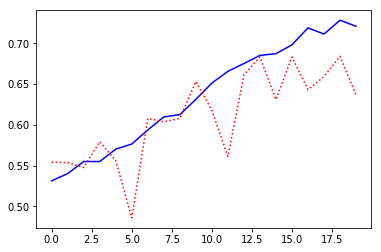

In [11]:
import matplotlib.pyplot as plt

plt.plot(history_1.history['acc'], 'b-', label="train set accuracy")
plt.plot(history_1.history['val_acc'], 'r:', label="dev set accuracy")